In [1]:
from pydantic import BaseModel, Field
import re

In [13]:
class Response(BaseModel):
    reasoning: str = Field(description="The reasoning for the final answer")
    final_answer: int = Field(description="The final answer to the problem as integer")

In [23]:
from langchain_openai import ChatOpenAI
import os

# Connect to OpenRouter
llm = ChatOpenAI(
    model="qwen/qwen3-14b",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

answer_extractor = ChatOpenAI(
    model="google/gemini-2.0-flash-001",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

answer_extractor = answer_extractor.with_structured_output(Response)


In [32]:
async def ask_qwen_structured(problem_text, attempts=3):
    results = []
    token_counts = []

    for _ in range(attempts):
        max_retries = 6
        retry_count = 0
        success = False
        
        while not success and retry_count < max_retries:
            try:
                prompt = (
                    "You are a math tutor. Answer the question and give your final answer in LaTeX boxed format, "
                    f"Problem:\n{problem_text}"
                    "Return your final answer in latex boxed format. so something like this: \\boxed{123}"
                )
                response = await llm.ainvoke(prompt)
                response_text = response.content.strip()

                resp = await answer_extractor.ainvoke("Given the following response, extract the final answer from it: " + response_text)

                results.append(resp.final_answer)

                # Extract token count
                usage = response.response_metadata.get("token_usage", {})
                token_counts.append(usage.get("total_tokens", None))
                
                success = True
            except Exception as e:
                retry_count += 1
                if retry_count >= max_retries:
                    print(f"❌ Error after {max_retries} retries: {e}")
                    results.append(None)
                    token_counts.append(None)
                else:
                    print(f"⚠️ Retry {retry_count}/{max_retries} due to error: {e}")
    return results, token_counts

In [33]:
import asyncio

async def process_problem(item):
    id = item.get("id", 0)
    problem = item["problem"]
    print(f"🔍 ID {id}")

    # Call async Qwen wrapper
    answers, token_counts = await ask_qwen_structured(problem)
    
    print('results for id', id)
    print(answers)
    print(token_counts)
    print('--------------------------------')

    return {
        "id": id,
        "problem": problem,
        "final_answers": answers,
        "token_counts": token_counts
    }

async def process_all(ds):
    tasks = [process_problem(item) for item in ds]
    return await asyncio.gather(*tasks)

In [34]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceH4/aime_2024", split="train")

In [35]:
import nest_asyncio
nest_asyncio.apply()

# Run the async pipeline
results = await process_all(ds)

🔍 ID 60
🔍 ID 61
🔍 ID 62
🔍 ID 63
🔍 ID 64
🔍 ID 65
🔍 ID 66
🔍 ID 67
🔍 ID 68
🔍 ID 69
🔍 ID 70
🔍 ID 71
🔍 ID 72
🔍 ID 73
🔍 ID 74
🔍 ID 75
🔍 ID 76
🔍 ID 77
🔍 ID 78
🔍 ID 79
🔍 ID 80
🔍 ID 81
🔍 ID 82
🔍 ID 83
🔍 ID 84
🔍 ID 85
🔍 ID 86
🔍 ID 87
🔍 ID 88
🔍 ID 89
results for id 69
[116, 116, 116]
[4516, 4285, 4774]
--------------------------------
⚠️ Retry 1/3 due to error: Expecting value: line 1203 column 1 (char 6611)
results for id 86
[55, 55, 55]
[4910, 3746, 6194]
--------------------------------
⚠️ Retry 1/3 due to error: Expecting value: line 1275 column 1 (char 7007)
results for id 71
[294, 294, 294]
[4764, 4235, 5958]
--------------------------------
results for id 60
[204, 204, 204]
[4894, 4519, 4735]
--------------------------------
⚠️ Retry 1/3 due to error: Expecting value: line 1435 column 1 (char 7887)
results for id 84
[33, 33, 33]
[5937, 6953, 5179]
--------------------------------
results for id 72
[540, 540, 540]
[6436, 7321, 4318]
--------------------------------
⚠️ Retry 1/3 due to error

In [43]:
# convert the results into a pandas dataframe with the following columns: Question ID	Question 	Expected Answer	Tokens1	GA1	IsCorrect1	Tokens2	GA2	IsCorrect2	Tokens3	GA3	IsCorrect3	Correct Count	Token Count
import pandas as pd

# Create a basic dataframe with just the simple columns first
df = pd.DataFrame({
    "Question ID": [item["id"] for item in results],
    "Question": [item["problem"] for item in results],
    "Expected Answer": [item["answer"] for item in ds]
})

# Add the token counts and answers columns
for i in range(3):
    df[f"Tokens{i+1}"] = [item["token_counts"][i] for item in results]
    df[f"GA{i+1}"] = [int(item["final_answers"][i]) if item["final_answers"][i] is not None else item["final_answers"][i] for item in results]
    # Convert both to the same type (int) before comparison to handle cases like 204.0 == 204
    df[f"IsCorrect{i+1}"] = df.apply(
        lambda row: int(row[f"GA{i+1}"]) == int(row["Expected Answer"]) 
        if pd.notnull(row[f"GA{i+1}"]) and pd.notnull(row["Expected Answer"]) 
        else False, 
        axis=1
    )

# Calculate summary columns
df["Correct Count"] = df[["IsCorrect1", "IsCorrect2", "IsCorrect3"]].sum(axis=1)
df["Token Count"] = df[["Tokens1", "Tokens2", "Tokens3"]].sum(axis=1)

# Display and save
df.to_csv("results.csv", index=False)
df

,Question ID,Question,Expected Answer,Tokens1,GA1,IsCorrect1,Tokens2,GA2,IsCorrect2,Tokens3,GA3,IsCorrect3,Correct Count,Token Count
0,60,Every morning Aya goes for a $9$-kilometer-lon...,204,4894.0,204.0,True,4519.0,204.0,True,4735,204,True,3,14148.0
1,61,Let $ABC$ be a triangle inscribed in circle $\...,113,15863.0,113.0,True,15765.0,123.0,False,11499,113,True,2,43127.0
2,62,Each vertex of a regular octagon is independen...,371,16510.0,123.0,False,18720.0,365.0,False,16510,123,False,0,51740.0
3,63,Define $f(x)=|| x|-\tfrac{1}{2}|$ and $g(x)=||...,385,18353.0,12.0,False,NaN,NaN,False,23278,123,False,0,41631.0
4,64,Let $p$ be the least prime number for which th...,110,11221.0,110.0,True,10965.0,110.0,True,12565,110,True,3,34751.0
5,65,Let $ABCD$ be a tetrahedron such that $AB=CD= ...,104,7348.0,104.0,True,8389.0,104.0,True,10891,104,True,3,26628.0
6,66,Let $\mathcal{B}$ be the set of rectangular bo...,721,8093.0,721.0,True,12950.0,721.0,True,7609,721,True,3,28652.0
7,67,"There exist real numbers $x$ and $y$, both gre...",025,8483.0,25.0,True,8975.0,25.0,True,5670,25,True,3,23128.0
8,68,Alice and Bob play the following game. A stack...,809,9970.0,809.0,True,8613.0,809.0,True,11019,809,True,3,29602.0
9,69,Jen enters a lottery by picking $4$ distinct n...,116,4516.0,116.0,True,4285.0,116.0,True,4774,116,True,3,13575.0


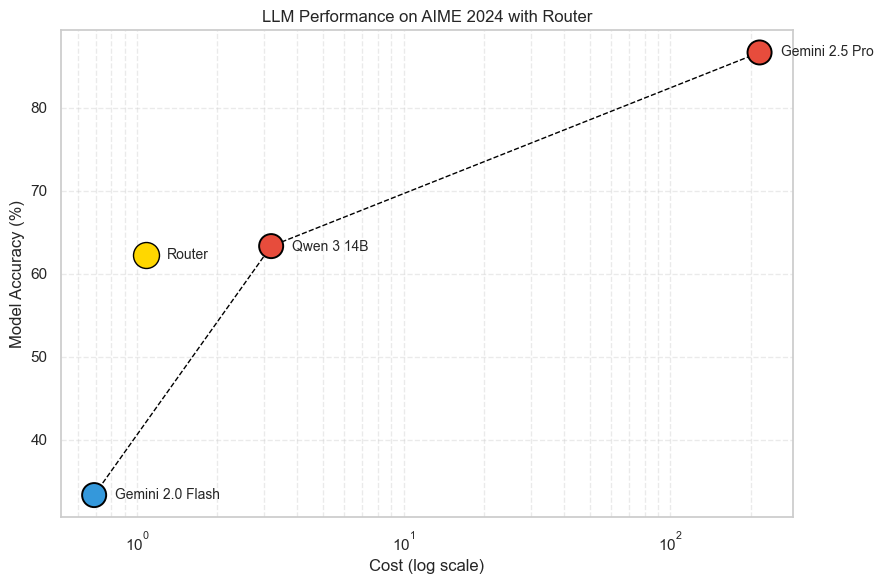

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the table data
data = {
    "Results": ["Gemini 2.5 Pro", "Gemini 2.0 Flash", "Qwen 3 14B", "Router"],
    "Accuracy": [86.66666667, 33.33333333, 63.33333333, 62.22222],
    "Token Count": [21592.57778, 1728.622222, 11380.88889, 33255.23333],
    "Price": [215.9257778, 0.6914488889, 3.186648889, 1.08349492]
}

df = pd.DataFrame(data)

# Step 2: Define which models are "thinking" models
thinking_status = {
    "Gemini 2.5 Pro": True,
    "Gemini 2.0 Flash": False,
    "Qwen 3 14B": True,
    "Router": False
}
df["Thinking"] = df["Results"].map(thinking_status)

# Step 3: Define color palette for thinking/non-thinking
palette = {
    True: "#e74c3c",   # Red for thinking
    False: "#3498db"   # Blue for non-thinking
}

# Step 4: Plotting
plt.figure(figsize=(9, 6))
sns.set(style="whitegrid")

# Separate router for custom styling
router_df = df[df["Results"] == "Router"]
others_df = df[df["Results"] != "Router"]

# Plot thinking/non-thinking models as circles without legend
scatter = sns.scatterplot(
    data=others_df,
    x="Price", y="Accuracy",
    hue="Thinking",
    palette=palette,
    s=300,
    edgecolor="black",
    zorder=3,
    marker='o',
    legend=False
)

# Plot Router in gold
plt.scatter(router_df["Price"], router_df["Accuracy"],
            color='gold', s=350, edgecolor='black', zorder=4, marker='o')

# Add labels (slightly offset to the right)
for _, row in df.iterrows():
    plt.text(row["Price"] * 1.2, row["Accuracy"], row["Results"], fontsize=10, va="center")

# Draw performance trend line: Flash → Qwen → Gemini Pro
line_models = ["Gemini 2.0 Flash", "Qwen 3 14B", "Gemini 2.5 Pro"]
line_data = df[df["Results"].isin(line_models)].sort_values("Price")
plt.plot(line_data["Price"], line_data["Accuracy"], linestyle='--', color="black", linewidth=1)

# Axes and styling
plt.xscale("log")
plt.xlabel("Cost (log scale)")
plt.ylabel("Model Accuracy (%)")
plt.title("LLM Performance on AIME 2024 with Router")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()